In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np

from utils.conn_data import load_pickle
from utils.diagnostics import compute_summary_statistics

plt.style.use('ggplot')

In [34]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
forecast_input = "wrds_etf_returns"
memory_input = "fredmd_transf"
vol_target = 0.15
portfolio_methods = ["naive"]

In [20]:
# load memory data and preprocess
memory_data = pd.read_csv(os.path.join(inputs_path, f'{memory_input}.csv'))

## fix dates
memory_data["date"] = pd.to_datetime(memory_data["date"])
memory_data = memory_data.set_index("date")

## compute moving average
memory_data = memory_data.rolling(window=12).mean()

## drop missing values
memory_data = memory_data.dropna()

returns = pd.read_csv(os.path.join(inputs_path, f'{forecast_input}.csv'))
returns = returns[[col for col in returns.columns if "t+1" not in col]]

## fix dates
returns["date"] = pd.to_datetime(returns["date"])
returns = returns.set_index("date")

## resample and match memory data dates
returns = returns.resample("B").last().ffill()
returns = pd.merge(returns, memory_data[[memory_data.columns[0]]], left_index=True, right_index=True).drop(memory_data.columns[0], axis=1)

## drop missing values
returns = returns.dropna()

In [21]:
os.listdir(os.path.join(outputs_path, "naive"))

['results_ls_3.pkl', 'results_lo_3.pkl']

In [22]:
all_portfolio_returns = []
for method in portfolio_methods:

    dirs = os.listdir(os.path.join(outputs_path, method))

    for dir in dirs:

        results = load_pickle(os.path.join(outputs_path, method, dir))
        
        # get forecasts
        forecasts = results['forecasts']
        forecasts.index = pd.to_datetime(forecasts.index)
        forecasts.index.name = "date"

        # check which dataframe haas the smallest number of rows and match dates
        if len(forecasts) < len(returns):
            returns = returns.loc[forecasts.index[0]:forecasts.index[-1]]
        else:
            forecasts = forecasts.loc[returns.index[0]:returns.index[-1]]

        # match columns
        forecasts = forecasts[returns.columns]

        # portfolio returns
        portfolio_returns = forecasts.multiply(returns, axis=0)

        long_only_tag = dir.split('.')[0].split('_')[1]
        num_assets_tag = dir.split('.')[0].split('_')[2]
        portfolio_returns["models"] = f"{method}_{long_only_tag}_{num_assets_tag}"

        all_portfolio_returns.append(portfolio_returns.reset_index().melt(["models", "date"]))
all_portfolio_returns_df = pd.concat(all_portfolio_returns)

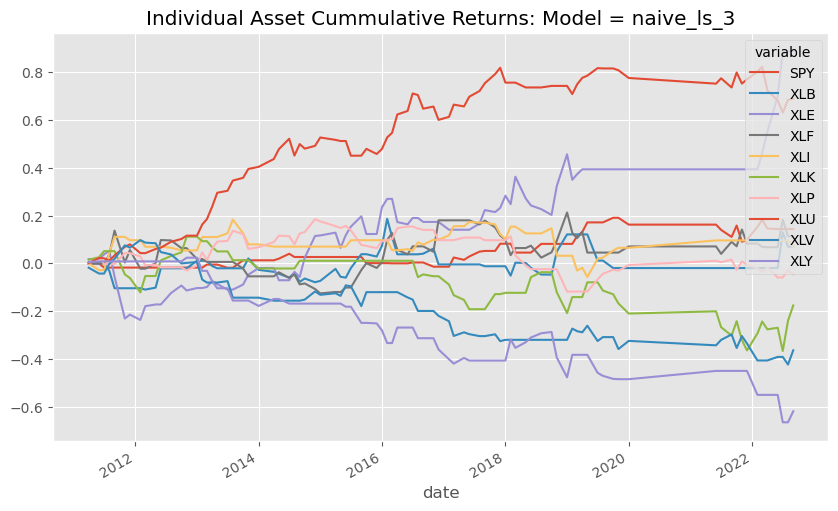

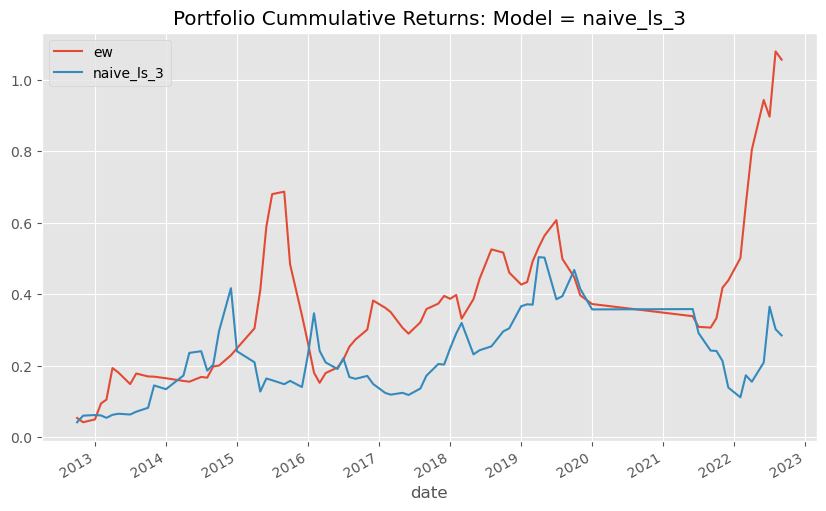

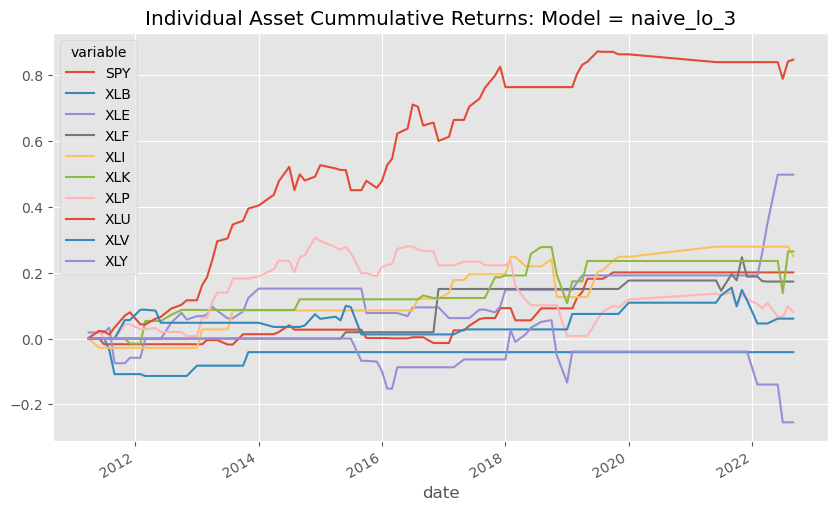

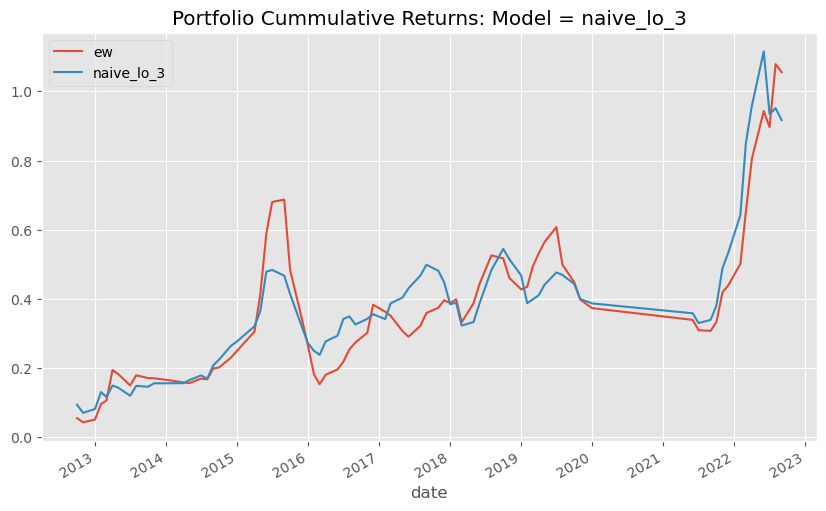

In [45]:
for model in all_portfolio_returns_df["models"].unique():
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")

    tmp_portfolio_returns.cumsum().plot(figsize=(10, 6), title=f"Individual Asset Cummulative Returns: Model = {model}")
    plt.show()

    # add equal weight
    equal_weight_cumm_returns = pd.DataFrame(returns.mean(axis=1).cumsum(), columns=["ew"])
    tmp_portfolio_cumm_returns = pd.DataFrame(tmp_portfolio_returns.mean(axis=1).cumsum(), columns=[model])
    cumm_returns_plot = pd.concat([equal_weight_cumm_returns, tmp_portfolio_cumm_returns], axis=1)

    # volatility scaling
    portfolio_vol = (cumm_returns_plot.rolling(window=12).std() * np.sqrt(12)).shift(1)
    portfolio_returns_target = (cumm_returns_plot * (vol_target / portfolio_vol)).dropna()

    portfolio_returns_target.plot(figsize=(10, 6), title=f"Portfolio Cummulative Returns: Model = {model}")
    plt.show()

In [47]:
all_summary_statistics = []
for model in all_portfolio_returns_df["models"].unique():
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")

    tensor_tmp_portfolio_returns = torch.tensor(tmp_portfolio_returns.mean(axis=1).values)
    summary_statistics = compute_summary_statistics(tensor_tmp_portfolio_returns)
    summary_statistics = pd.DataFrame([summary_statistics], index=[model])

    all_summary_statistics.append(summary_statistics)
all_summary_statistics_df = pd.concat(all_summary_statistics)

all_summary_statistics_df

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
naive_ls_3,1.047675,2.899615,0.361315,0.533371,-1.964989,-5.776624,0.590909
naive_lo_3,2.833938,3.508567,0.807720,0.939872,-0.879746,-5.790972,0.659091
